In [1]:
import numpy as np
import xarray as xr
import scipy
from scipy import stats
import scipy.special as sp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from glob import glob
import os

In [2]:
#Load data
cFlx = xr.open_mfdataset(sorted(glob('/Users/marki/Downloads/CERES_FluxByCldTyp-MON_Terra-Aqua-MODIS_Ed4.1_Subset_allsky_clearsky.nc')))

cldtypes = ['Cu','Sc','St','Ac','As','Ns','Ci','Cs', 'Cb']
dFlx = {} #Each cloud type aggregated separately
for cldtype in cldtypes:
    dFlx[cldtype] = xr.open_dataset('/Users/marki/Downloads/%s_climo_mon.nc' % cldtype)
   # print(dFlx[cldtype]['toa_albedo_cldtyp_mon'].shape)
syn = xr.open_mfdataset(sorted(glob('/Users/marki/Downloads/CERES_SSF1deg-Month_Aqua-MODIS_Ed4.1_Subset_200207-202203.nc')))
colors = {'Cu' : cm.Blues(.25), 'Sc' : cm.Blues(.5), 'St' : cm.Blues(.75), 'Ac' : cm.Purples(.25), 'As' : cm.Purples(.5), 'Ns' : cm.Purples(.75), 'Ci' : cm.Reds(.25), 'Cs' : cm.Reds(.5), 'Cb' : cm.Reds(.75),'all' : '.5'}

In [3]:
print(cldtypes)

['Cu', 'Sc', 'St', 'Ac', 'As', 'Ns', 'Ci', 'Cs', 'Cb']


### Define Functions

In [4]:
#
###Functions to calculate cloud fraction and albedo
#

def get_A_binned(ct,bin_width=.1):
    """
    Bin albedo values by cloud fraction for a given cloud type
    
    Parameters
    ----------
    ct : str
    Cloud type ('Cu','Sc','St','Ac','As','Ns','Ci','Cs', or 'Cb')
    
    bin_width : float
    Width of cloud fraction bins. Default is 0.1 (10%)
    
    Returns
    -------
    Cbinc : array
    Centers of cloud fraction bins
    
    A_binned : array-like
    List of arrays of albedo data for each cloud fraction bin
    """

    CF_ = np.ravel(dFlx[ct]['cldarea_cldtyp_mon'][:,30:150,:]/100)
    Ac_ = np.ravel(dFlx[ct]['toa_albedo_cldtyp_mon'][:,30:150,:])
    As_ = np.ravel(cFlx['toa_sw_clr_mon'][:,30:150,:]/cFlx['toa_solar_all_mon'][:,30:150,:])
    A_ = CF_*Ac_ + (1-CF_)*As_

    #Mask out invalid data (NaNs, land, ice)
    ocn = np.ravel(syn['aux_ocean_mon'][0:234,30:150,:]) == 100
    nan = np.logical_or(np.isnan(CF_),np.isnan(A_))
    valid = np.logical_and(ocn,~nan)

    CF = CF_[valid]
    A = A_[valid]

    Cbinc = np.arange(bin_width/2,1,bin_width)
    A_binned = [(A[np.logical_and(CF>Cc-bin_width/2,CF<=Cc+bin_width/2)]) for Cc in Cbinc]
    
    return Cbinc, A_binned



In [ ]:
#print(Cbinc)

In [5]:
 def get_SWrCRE_binned(ct,bin_width=.1):
    """
    Bin SW rCRE values by cloud fraction for a given cloud type
    
    Parameters
    ----------
    ct : str
    Cloud type ('Cu','Sc','St','Ac','As','Ns','Ci','Cs', or 'Cb')
    
    bin_width : float
    Width of cloud fraction bins. Default is 0.1 (10%)
    
    Returns
    -------
    Cbinc : array
    Centers of cloud fraction bins
    
    SWrCRE_binned : array-like
    List of arrays of SW rCRE data for each cloud fraction bin
    """
    CF_ = np.ravel(dFlx[ct]['cldarea_cldtyp_mon'][:,30:150,:]/100)
    Ac_ = np.ravel(dFlx[ct]['toa_albedo_cldtyp_mon'][:,30:150,:])
    As_ = np.ravel(cFlx['toa_sw_clr_mon'][:,30:150,:]/cFlx['toa_solar_all_mon'][:,30:150,:])
    
    rCRE_ = CF_*(Ac_-As_)

    #Mask out invalid data (NaNs, land, ice)
    ocn = np.ravel(syn['aux_ocean_mon'][0:234,30:150,:]) == 100
    nan = np.logical_or(np.isnan(CF_),np.isnan(rCRE_))
    valid = np.logical_and(ocn,~nan)

    CF = CF_[valid]
    rCRE = rCRE_[valid]

    Cbinc = np.arange(bin_width/2,1,bin_width)
    rCRE_binned = [(rCRE[np.logical_and(CF>Cc-bin_width/2,CF<=Cc+bin_width/2)]) for Cc in Cbinc]
    
    return Cbinc, rCRE_binned

In [6]:
def get_R_binned(ct,spec='sw',bin_width=.1):
    """
    Bin relative cloud enhancement factor (R) values by cloud fraction for a given cloud type
    
    Parameters
    ----------
    ct : str
    Cloud type ('Cu','Sc','St','Ac','As','Ns','Ci','Cs', or 'Cb') or 'all' for all-sky
    
    spec : str
    Spectral band; 'sw' for shortwave (default) or 'lw' for longwave
    
    bin_width : float
    Width of cloud fraction bins. Default is 0.1 (10%)
    
    Returns
    -------
    Cbinc : array
    Centers of cloud fraction bins
    
    R_binned : array-like
    List of arrays of R data for each cloud fraction bin
    """

    Fclr_ = np.ravel(cFlx['toa_%s_clr_mon' % spec][:,30:150,:])
    
    if ct == 'all':
        CF_ = np.ravel(cFlx['cldarea_total_mon'][:,30:150,:]/100)
        Fall_ = np.ravel(cFlx['toa_%s_all_mon' % spec][:,30:150,:])
        Fcld_ = np.ravel((Fall_-(1-CF_)*Fclr_)/CF_)
    
    else:
        CF_ = np.ravel(dFlx[ct]['cldarea_cldtyp_mon'][:,30:150,:]/100)
        Fcld_ = np.ravel(dFlx[ct]['toa_%s_cldtyp_mon' % spec][:,30:150,:])
    #print(Fclr_.shape)
    #print(Fcld_.shape)
    #print(CF_.shape)
    R_ = CF_*(1-Fcld_/Fclr_)

    #Mask out invalid data (NaNs, land, ice)
    ocn = np.ravel(syn['aux_ocean_mon'][0:234,30:150,:]) == 100
    nan = np.logical_or(np.isnan(CF_),np.isnan(R_))
    valid = np.logical_and(ocn,~nan)

    CF = CF_[valid]
    R = R_[valid]

    Cbinc = np.arange(bin_width/2,1,bin_width)
    R_binned = [(R[np.logical_and(CF>Cc-bin_width/2,CF<=Cc+bin_width/2)]) for Cc in Cbinc]
    
    return Cbinc, R_binned

In [ ]:
#Cbinc, R_binned= get_R_binned(cldtype,spec='sw',bin_width=.1)


In [7]:
#
###Plotting functions
#

def scatter_plot_A(ct,bin_width=.1,save=False):
    """
    Create scatter plot for given cloud type
    
    Parameters
    ----------
    ct : str
    Cloud type ('Cu','Sc','St','Ac','As','Ns','Ci','Cs', or 'Cb')
    
    bin_width : float
    Width of cloud fraction bins. Default is 0.1 (10%)
    
    save : bool
    If True, save plot as png
    """
    
    #Get cloud fraction bins and binned albedo data
    Cbinc, A_binned = get_A_binned(ct,bin_width)

    #Calculate mean, IQR, and number of samples for each bin
    centers = []
    means = []
    emin = []
    emax = []
    N = []
    for i in range(len(A_binned)):
        if len(A_binned[i]) > 0: #Errors if trying to take mean of empty bin
            centers.append(Cbinc[i])
            means.append(np.mean(A_binned[i]))
            emin.append(np.percentile(A_binned[i],25))
            emax.append(np.percentile(A_binned[i],75))
            N.append(len(A_binned[i]))
    centers = np.array(centers)
    means = np.array(means)
    emin = np.array(emin)
    emax = np.array(emax)
    N = np.array(N)

    #Plot data
    plt.figure(figsize=(12,10))
    plt.clf()
    fs = 20
    plt.scatter(centers,means,s=N/1000,facecolor=colors[ct],edgecolors='k',lw=1)
    plt.errorbar(centers,means,yerr=np.array((means-emin,emax-means)),color='k',lw=2,fmt='none',capsize=4)

    plt.yticks(fontsize=fs-2)
    plt.ylabel('All-sky albedo for %s scenes' % ct,fontsize=fs)
    plt.xticks(fontsize=fs-2)
    plt.xlabel('%s cloud fraction' % ct,fontsize=fs)
    plt.xlim(0,1)

    if save:   plt.savefig('/Users/marki/Documents/AC_scatterplot_%s.png' % ct,dpi=150)

def scatter_plot_rCRE(ct,bin_width=.05,save=False):
    """
    Create scatter plot for given cloud type for SW rCRE-cloud fraction relationships
    
    Parameters
    ----------
    ct : str
    Cloud type ('Cu','Sc','St','Ac','As','Ns','Ci','Cs', or 'Cb')
    
    bin_width : float
    Width of cloud fraction bins. Default is 0.1 (10%)
    
    save : bool
    If True, save plot as png
    """
    
    #Get cloud fraction bins and binned rCRE data
    Cbinc, rCRE_binned = get_SWrCRE_binned(ct,bin_width)

    #Calculate mean, IQR, and number of samples for each bin
    centers = []
    means = []
    emin = []
    emax = []
    N = []
    for i in range(len(rCRE_binned)):
        if len(rCRE_binned[i]) > 0: #Errors if trying to take mean of empty bin
            centers.append(Cbinc[i])
            means.append(np.mean(rCRE_binned[i]))
            emin.append(np.percentile(rCRE_binned[i],25))
            emax.append(np.percentile(rCRE_binned[i],75))
            N.append(len(rCRE_binned[i]))
    centers = np.array(centers)
    means = np.array(means)
    emin = np.array(emin)
    emax = np.array(emax)
    N = np.array(N)

    #Plot data
    plt.figure(figsize=(12,10))
    plt.clf()
    fs = 20

    plt.scatter(centers,means,s=N/1000,facecolor=colors[ct],edgecolors='k',lw=1)
    plt.errorbar(centers,means,yerr=np.array((means-emin,emax-means)),color='k',lw=2,fmt='none',capsize=4)

    plt.yticks(fontsize=fs-2)
    plt.ylabel('SW relative cloud radiative effect',fontsize=fs)
    plt.xticks(fontsize=fs-2)
    plt.xlabel('%s cloud fraction' % ct,fontsize=fs)
    plt.xlim(0,1)
    plt.title(ct,fontsize=fs+4)

    if save: plt.savefig('/Users/marki/Documents/rCRE-C_scatterplot_%s.png' % ct,dpi=150)


def scatter_plot_R(ct='Sc',spec='sw',bin_width=.05,save=False):
    """
    Create scatter plot for given cloud type for relative cloud enhancement factor-cloud fraction relationships
    
    Parameters
    ----------
    ct : str
    Cloud type ('Cu','Sc','St','Ac','As','Ns','Ci','Cs', or 'Cb') or 'all' for all-sky
    
    spec : str
    Spectral band; 'sw' for shortwave (default) or 'lw' for longwave
    
    bin_width : float
    Width of cloud fraction bins. Default is 0.1 (10%)
    
    save : bool
    If True, save plot as png
    """
    
    #Get cloud fraction bins and binned rCRE data
    Cbinc, R_binned = get_R_binned(ct,spec,bin_width)

    #Calculate mean, IQR, and number of samples for each bin
    centers = []
    means = []
    emin = []
    emax = []
    N = []
    for i in range(len(R_binned)):
        if len(R_binned[i]) > 0: #Errors if trying to take mean of empty bin
            centers.append(Cbinc[i])
            means.append(np.mean(R_binned[i]))
            emin.append(np.percentile(R_binned[i],25))
            emax.append(np.percentile(R_binned[i],75))
            N.append(len(R_binned[i]))
    centers = np.array(centers)
    means = np.array(means)
    emin = np.array(emin)
    emax = np.array(emax)
    N = np.array(N)

    #Plot data
    plt.figure(figsize=(12,10))
    plt.clf()
    fs = 20

    plt.scatter(centers,means,s=N/1000,facecolor=colors[ct],edgecolors='k',lw=1)
    plt.errorbar(centers,means,yerr=np.array((means-emin,emax-means)),color='k',lw=2,fmt='none',capsize=4)
    
    plt.plot([0,1],[0,0],'k--',lw=1,zorder=0)

    plt.yticks(fontsize=fs-2)
    if spec == 'sw': plt.ylabel('SW relative cloud radiative effect',fontsize=fs)
    elif spec == 'lw': plt.ylabel('LW relative cloud radiative effect',fontsize=fs)
    plt.xticks(fontsize=fs-2)
    plt.xlabel('%s cloud fraction' % ct,fontsize=fs)
    plt.xlim(0,1)
    plt.title(ct,fontsize=fs+4)

    if save: plt.savefig('/Users/marki/Documents/R%s-C_scatterplot_%s.png' % (spec,ct),dpi=150)


In [28]:
def all_graphs(cldtype):
    Cbinc,A_binned=get_A_binned(cldtype,bin_width=.1)
    Cbinc, SWrCRE_binned= get_SWrCRE_binned(cldtype,bin_width=.1)
    Cbinc, R_binned= get_R_binned(cldtype,spec='sw',bin_width=.1)
    scatter_plot_A(cldtype,bin_width=.1,save=False)
    scatter_plot_rCRE(cldtype,bin_width=.05,save=False)
    scatter_plot_R(ct=cldtype,spec='lw',bin_width=.05,save=False)

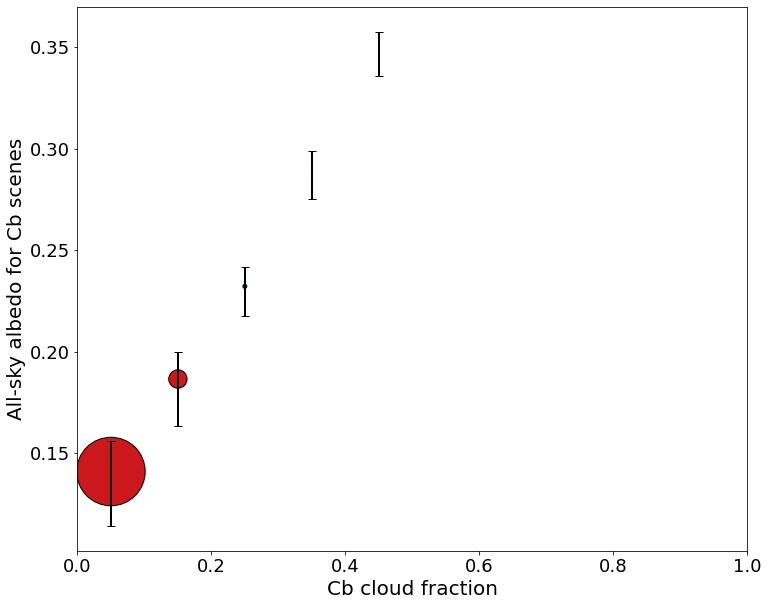

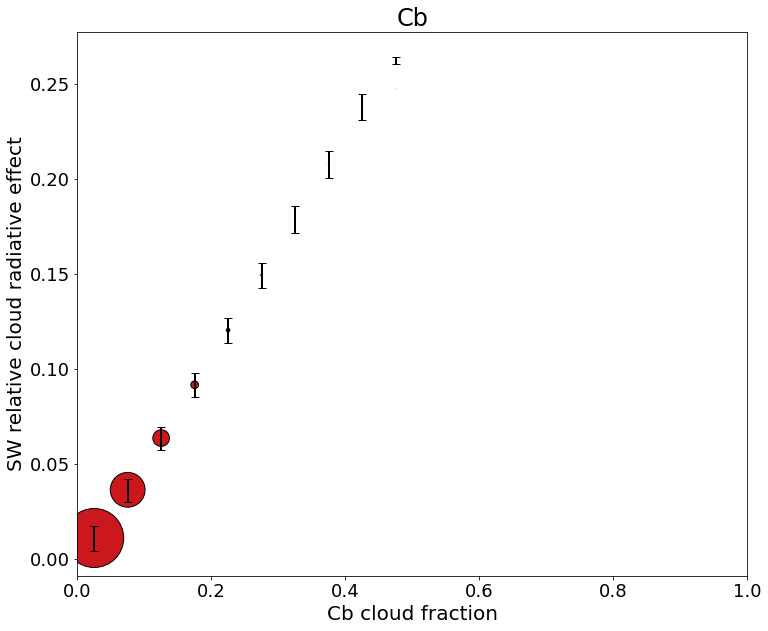

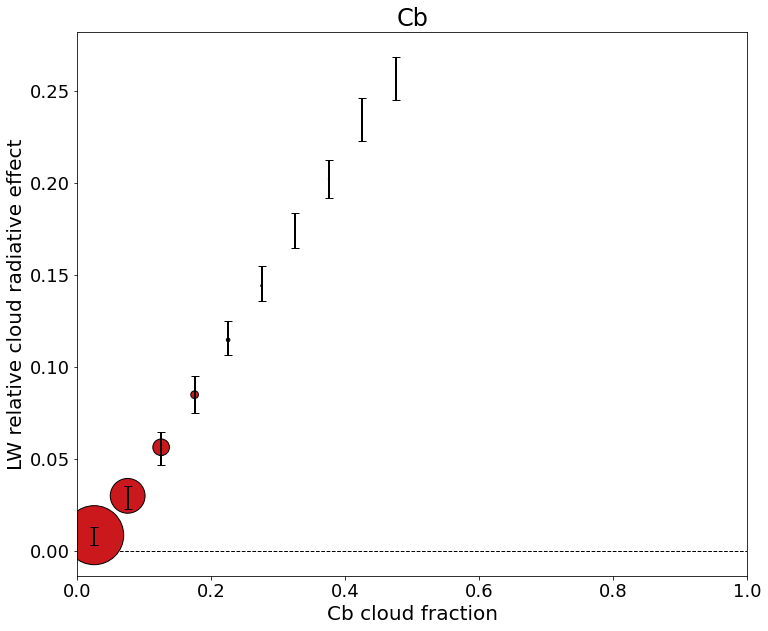

In [13]:
all_graphs('Cb')


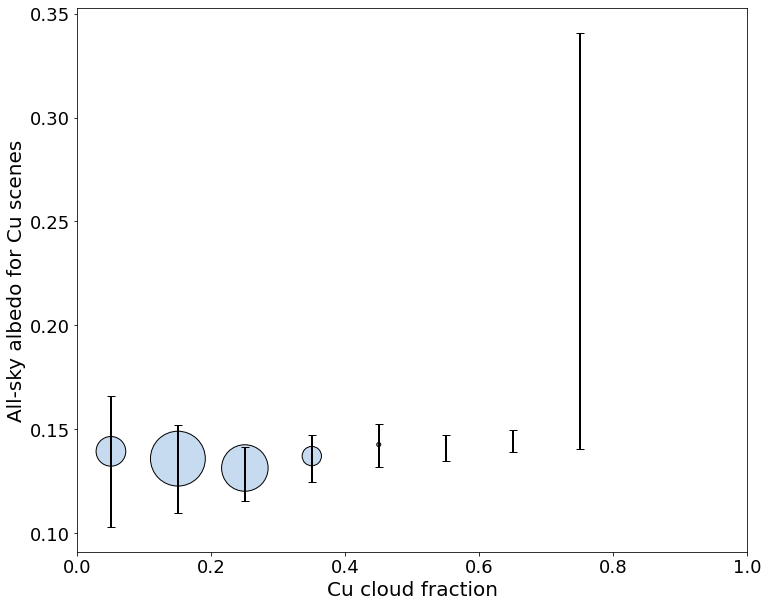

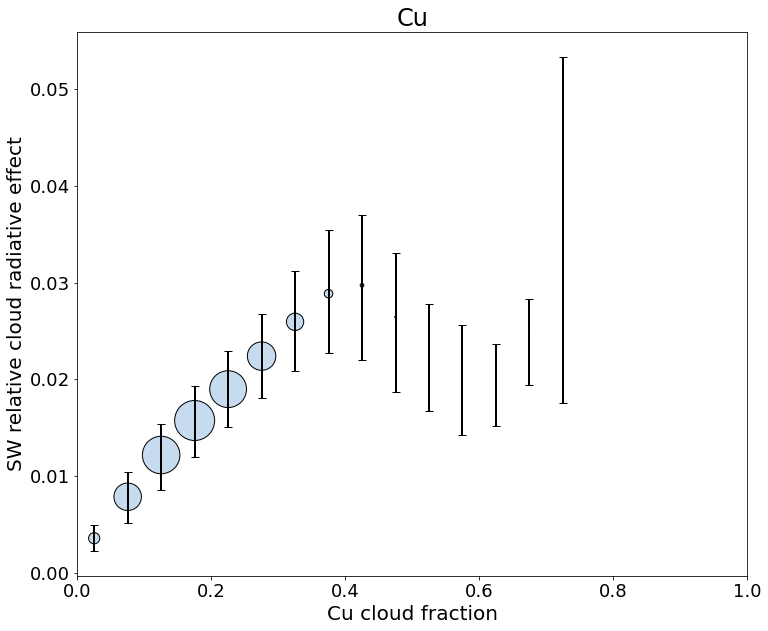

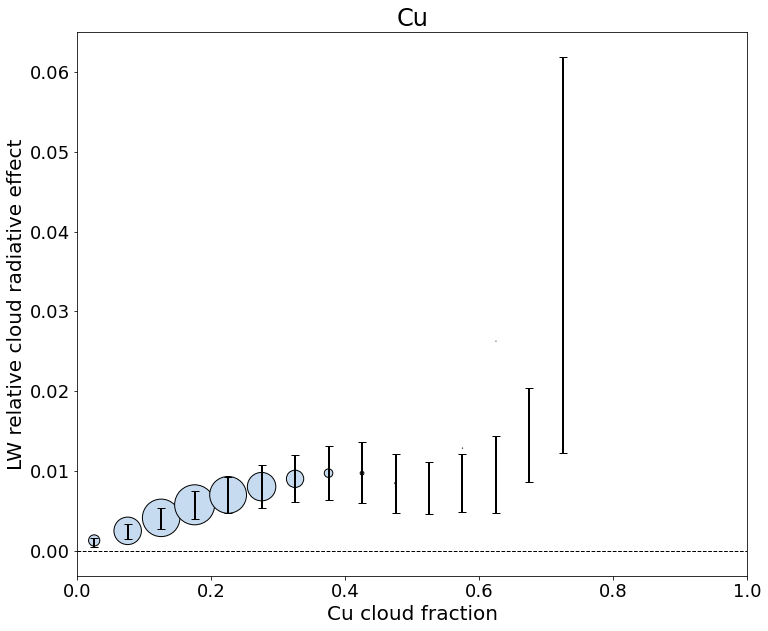

In [14]:
all_graphs('Cu')

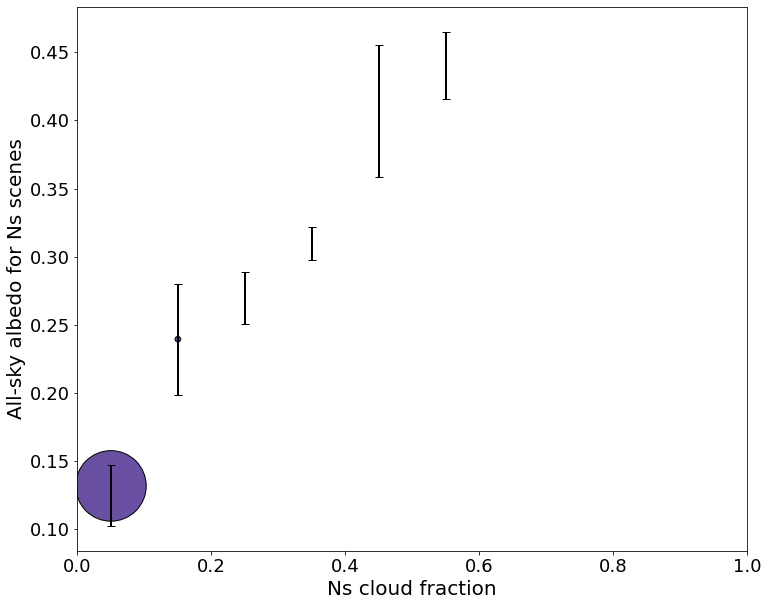

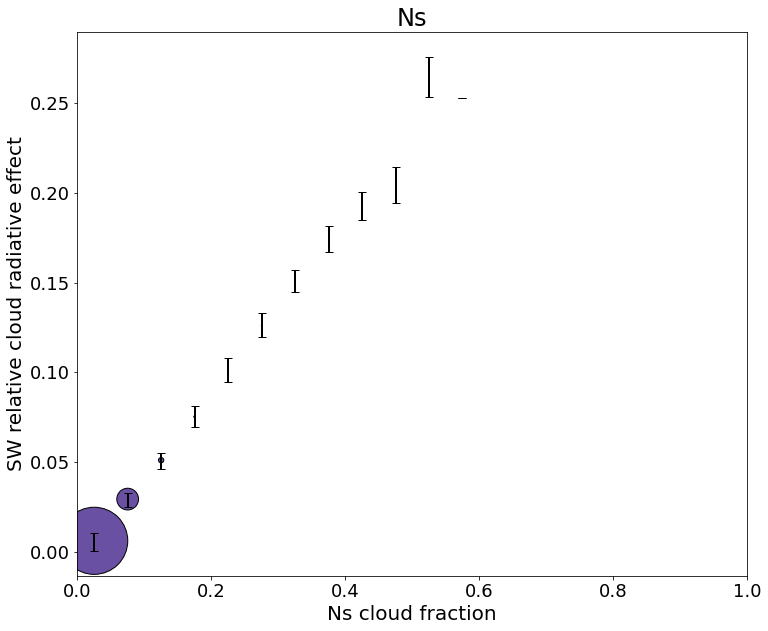

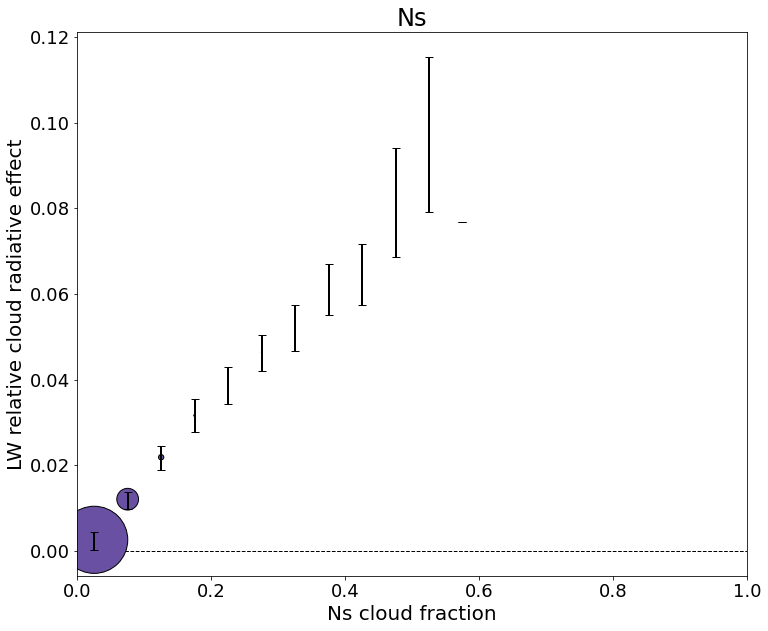

In [15]:
all_graphs('Ns')

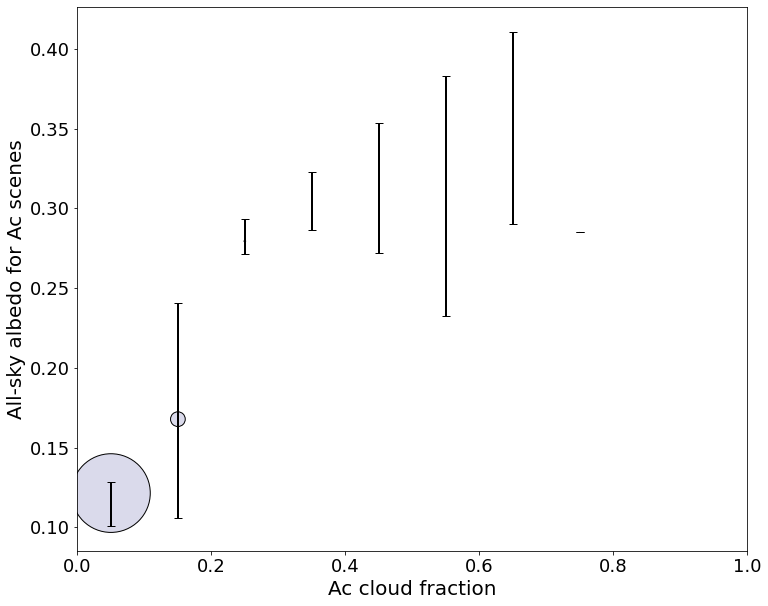

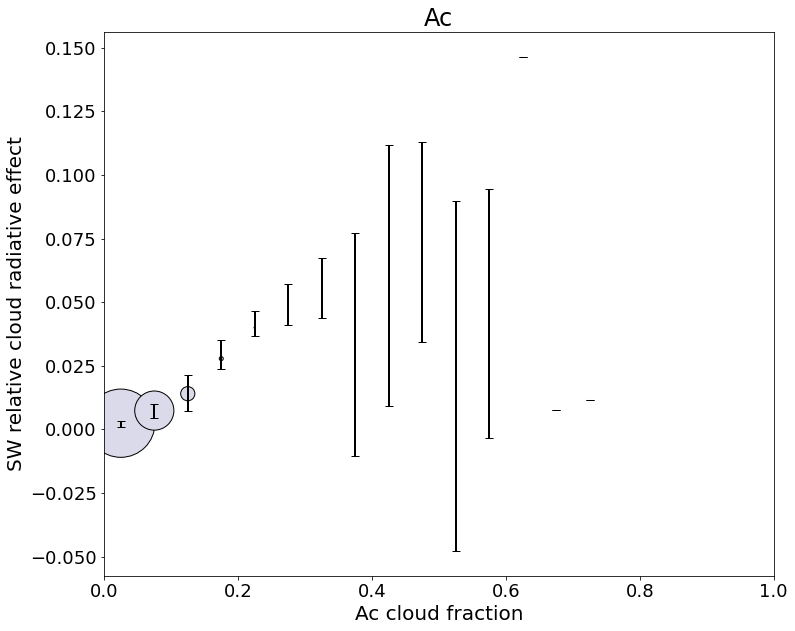

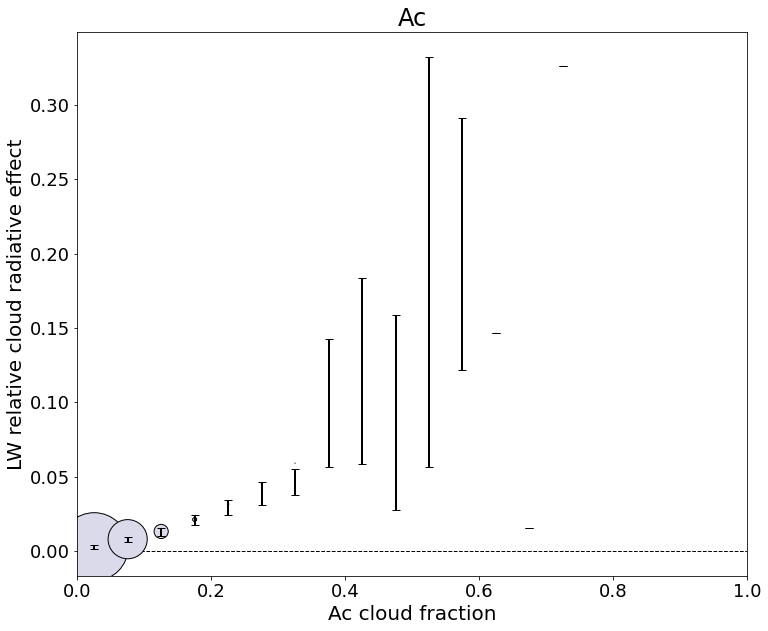

In [16]:
all_graphs('Ac')

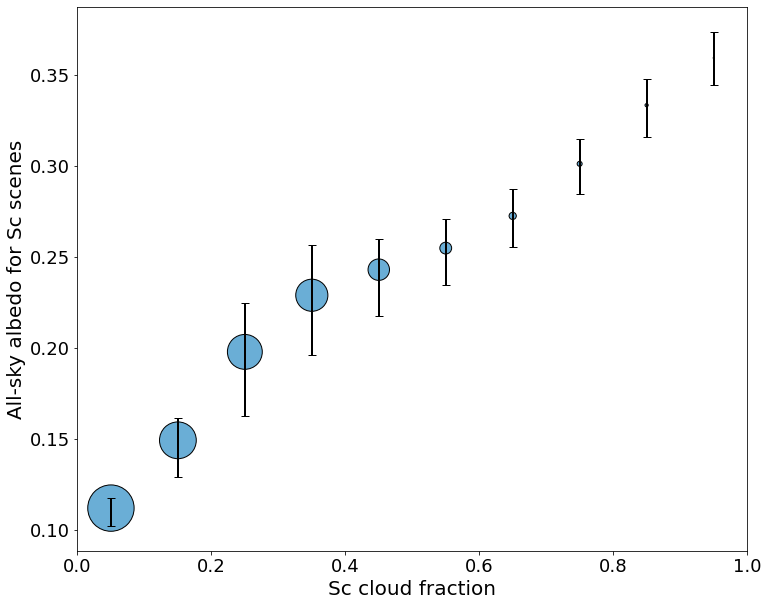

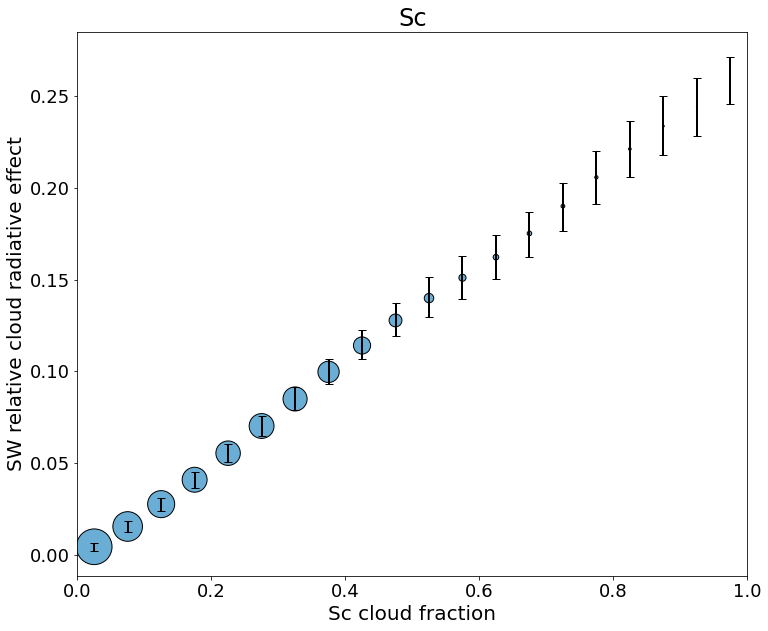

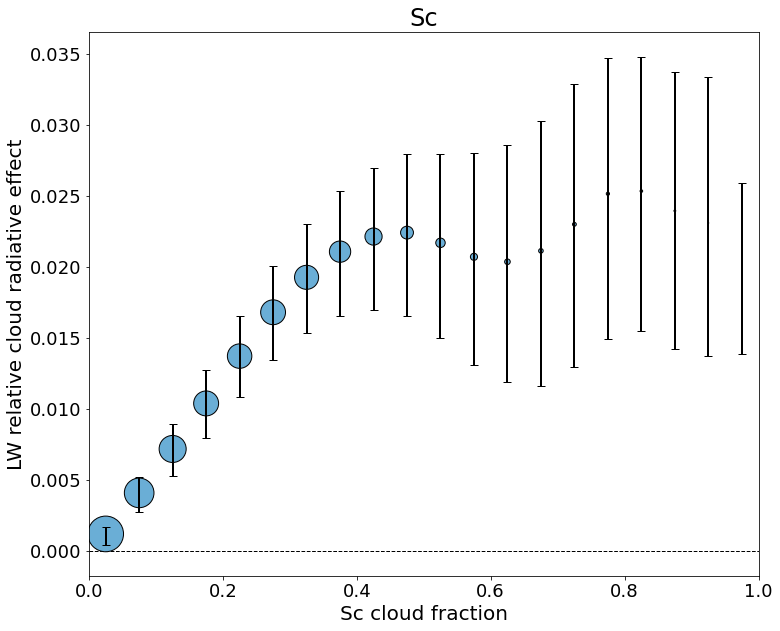

In [17]:
all_graphs('Sc')

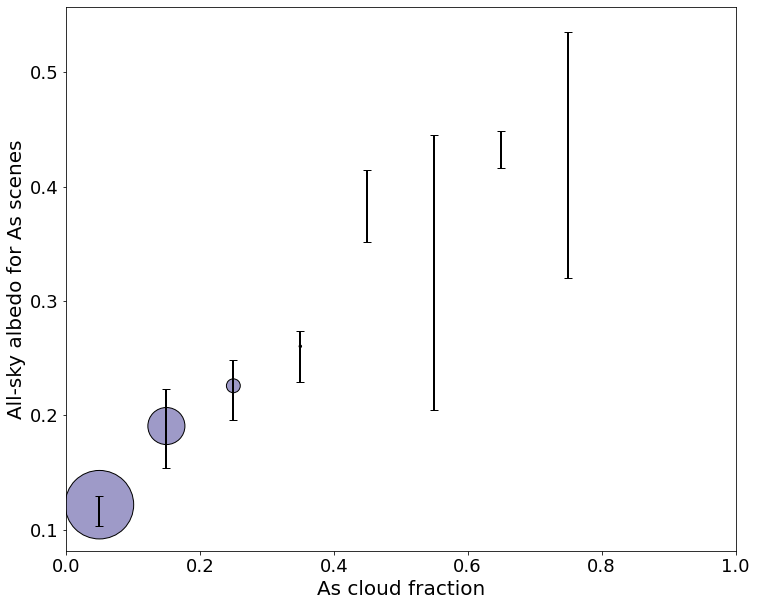

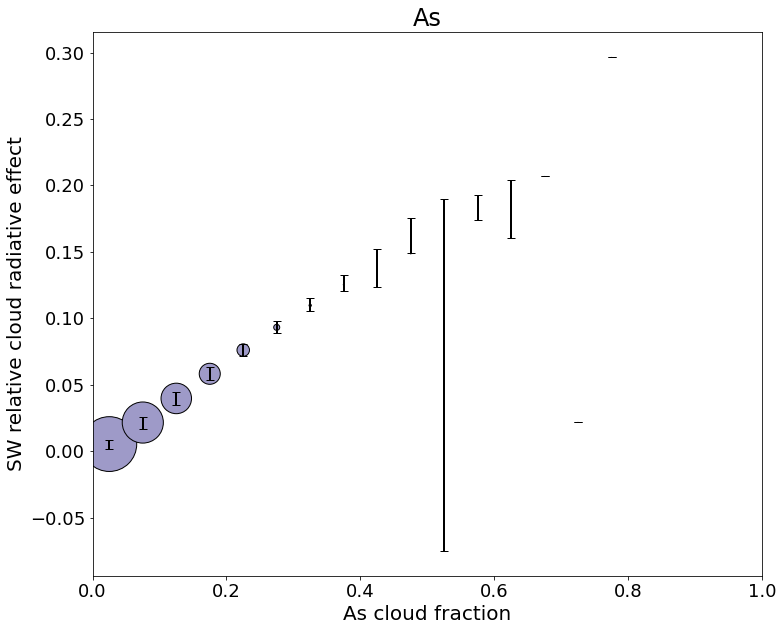

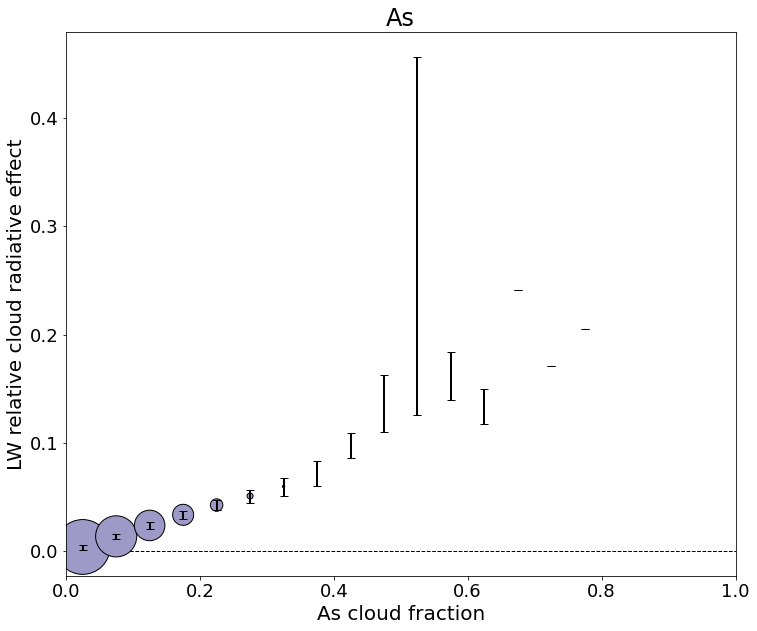

In [18]:
all_graphs('As')

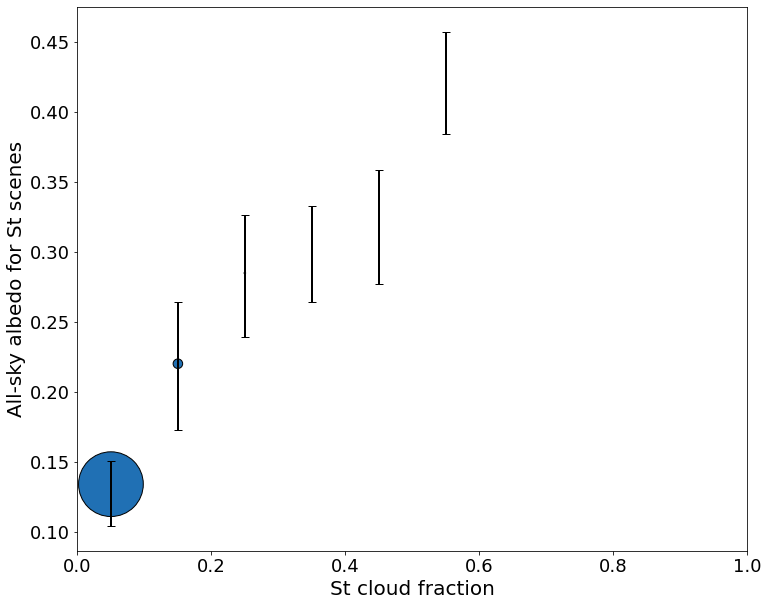

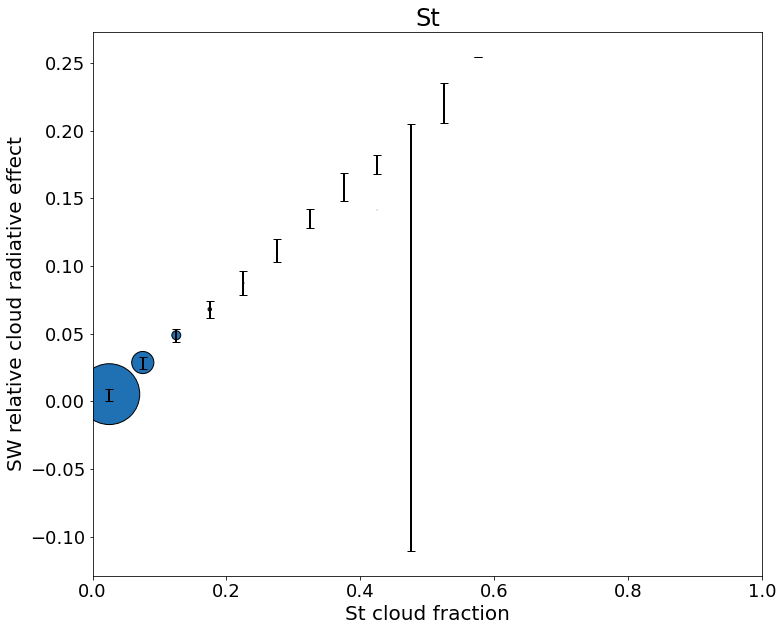

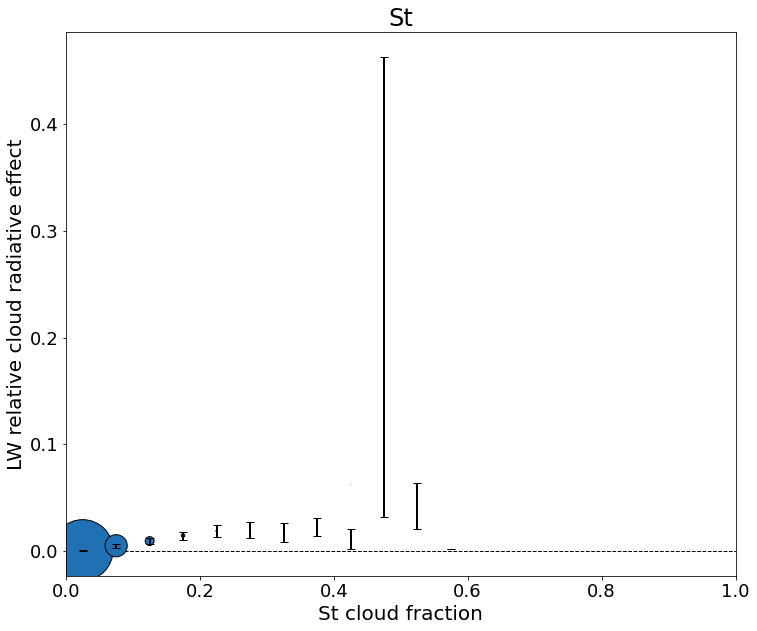

In [19]:
all_graphs('St')

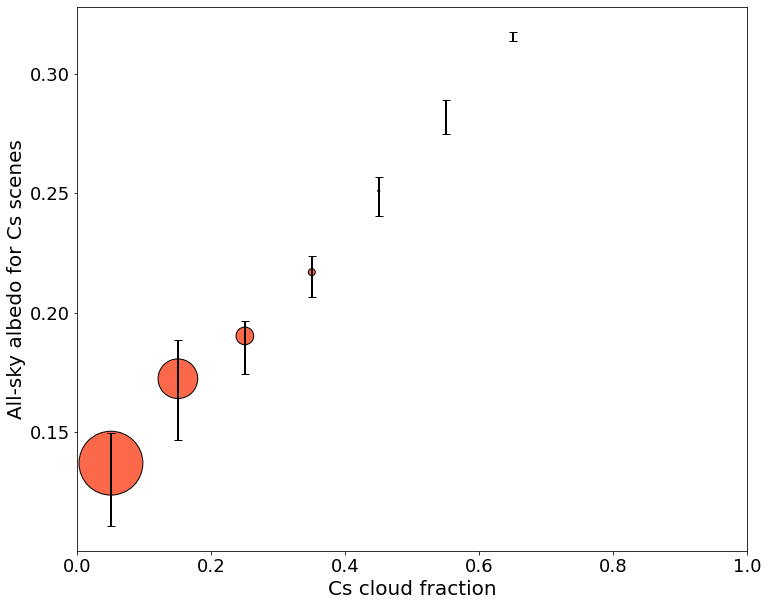

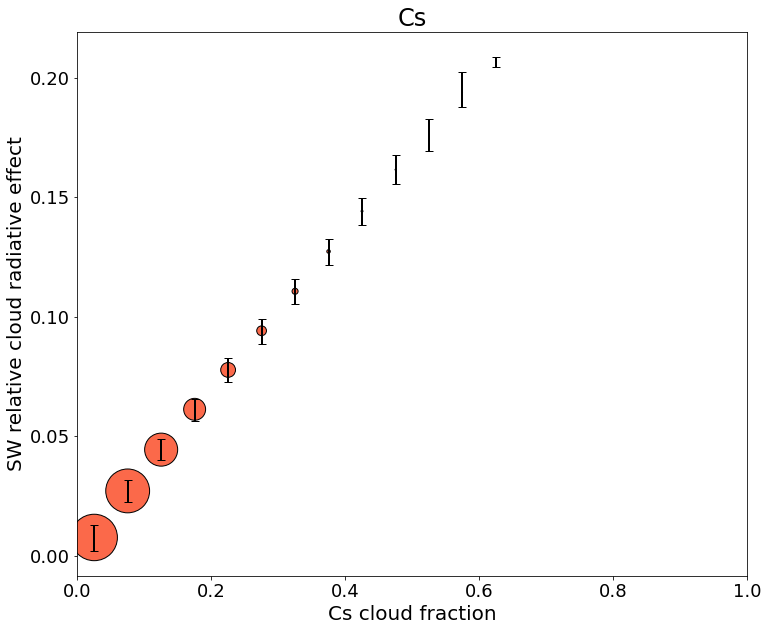

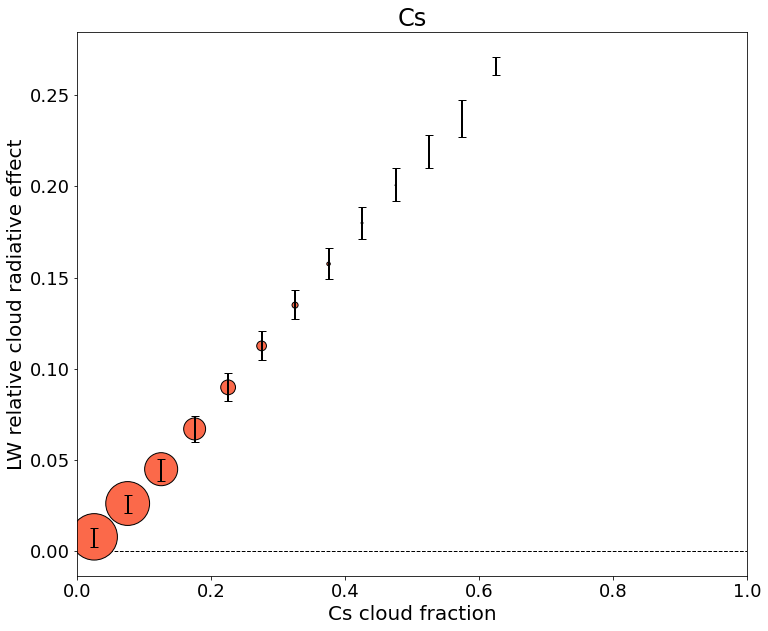

In [20]:
all_graphs('Cs')

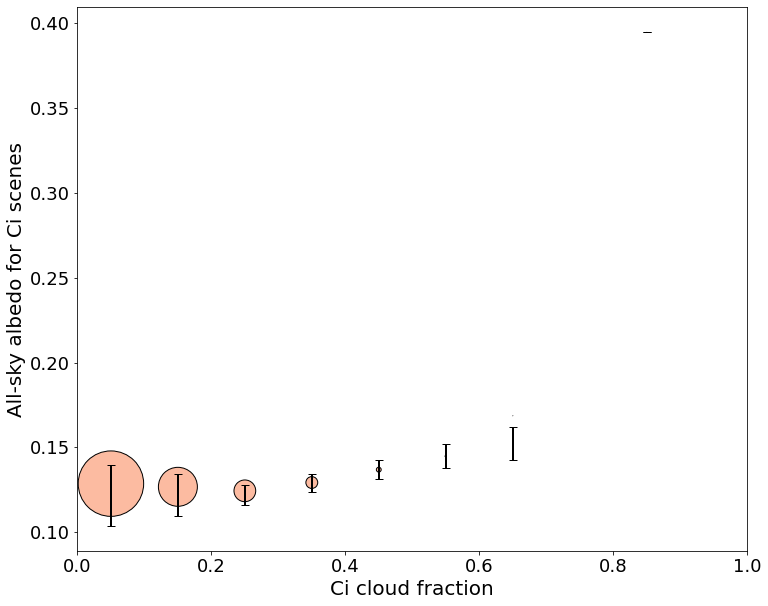

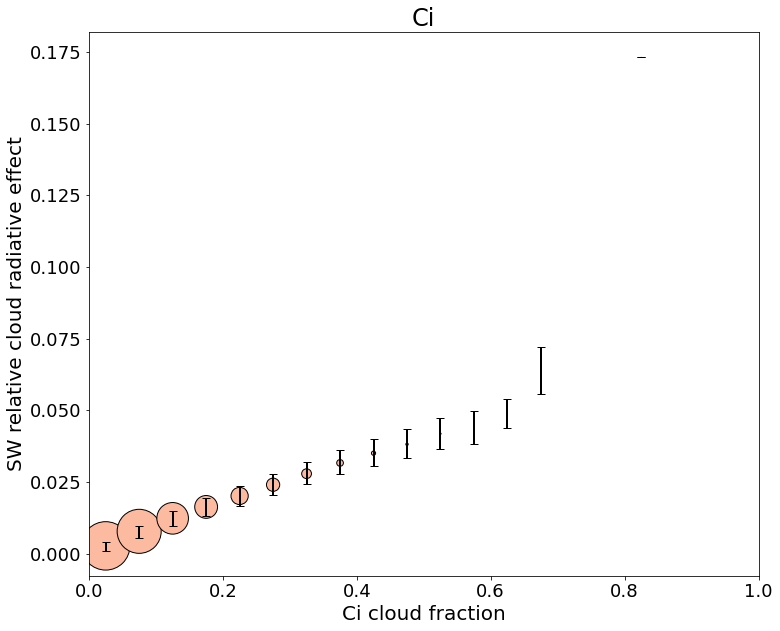

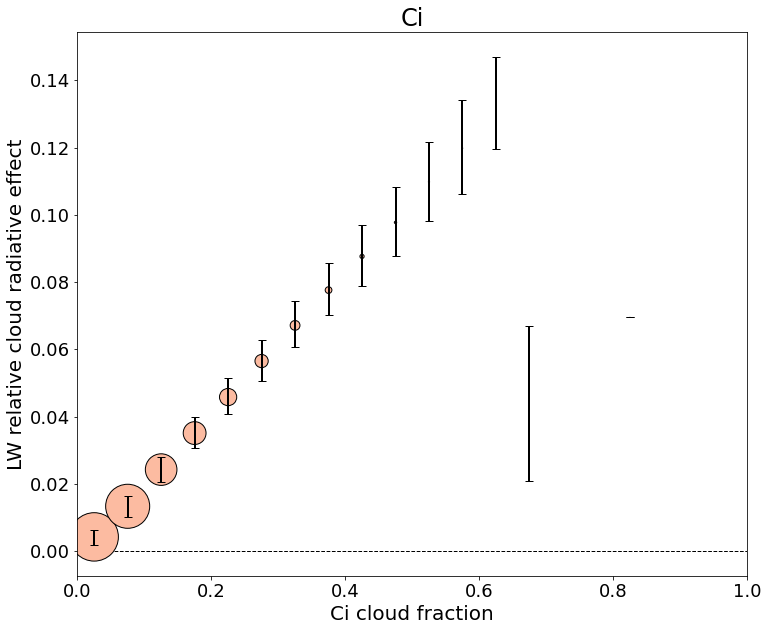

In [21]:
all_graphs('Ci')

In [25]:
def all_graphs_(cldtype):
   # Cbinc,A_binned=get_A_binned(cldtype,bin_width=.1)
    #Cbinc, SWrCRE_binned= get_SWrCRE_binned(cldtype,bin_width=.1)
    Cbinc, R_binned= get_R_binned(cldtype,spec='lw',bin_width=.1)
    #scatter_plot_A(cldtype,bin_width=.1,save=False)
    #scatter_plot_rCRE(cldtype,bin_width=.05,save=False)
    scatter_plot_R(ct=cldtype,spec='lw',bin_width=.05,save=False)

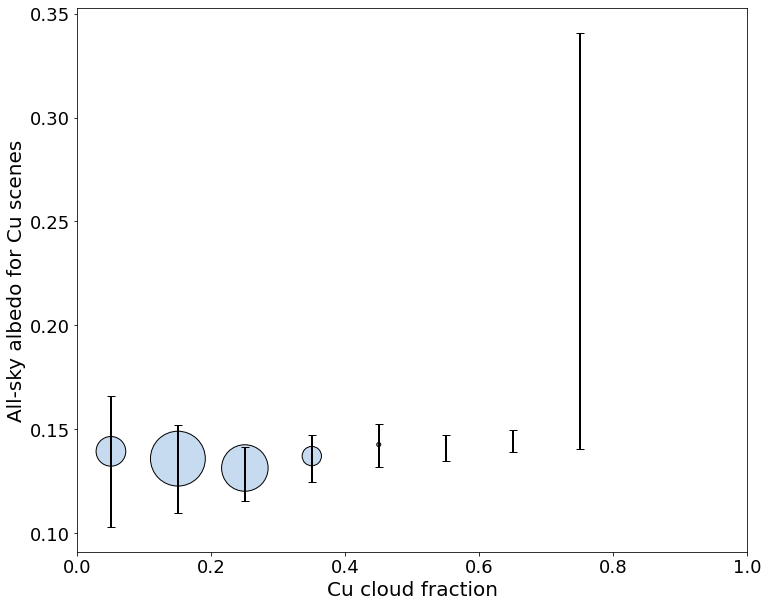

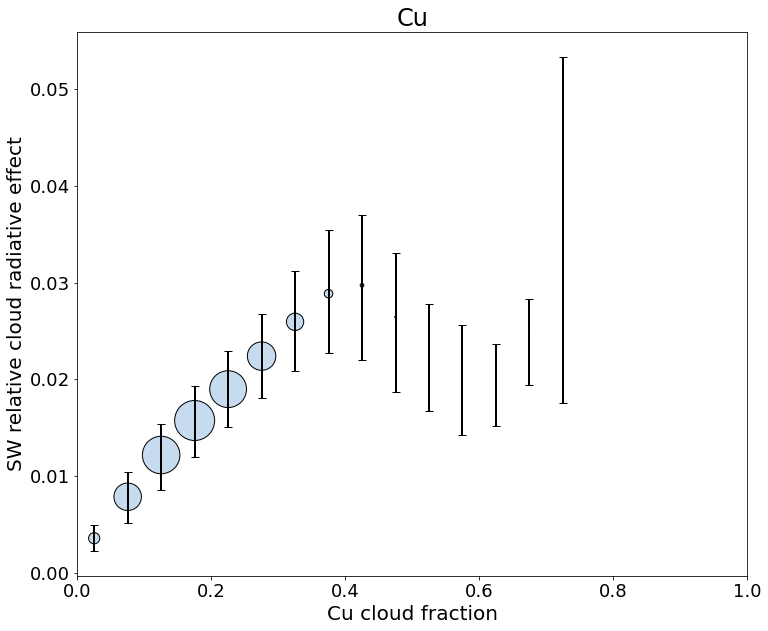

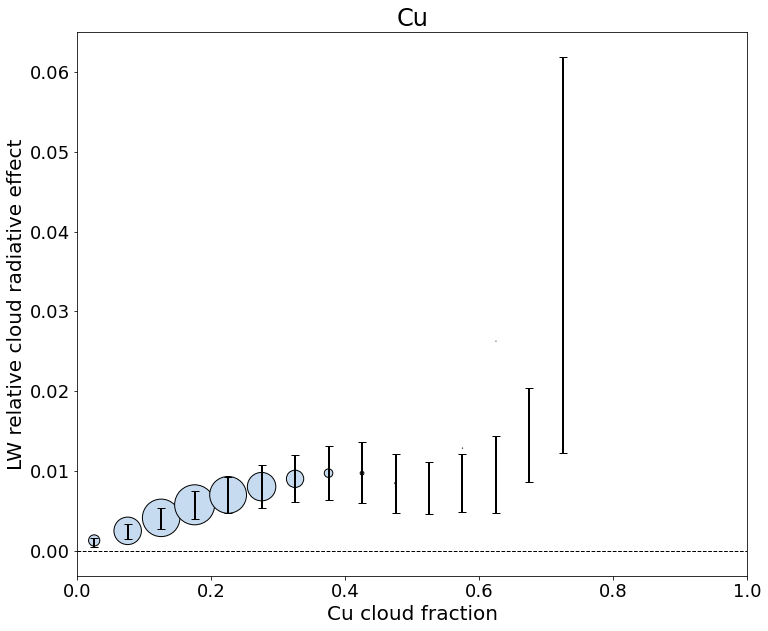

In [26]:
all_graphs('Cu')

### Sandbox

In [ ]:
def OLS(ct,):
    
    CF_ = np.ravel(dFlx[ct]['cldarea_cldtyp_mon']/100)
    Ac_ = np.ravel(dFlx[ct]['toa_albedo_cldtyp_mon'])
    As_ = np.ravel(cFlx['toa_sw_clr_mon']/cFlx['toa_solar_all_mon'])
    A_ = CF_*Ac_ + (1-CF_)*As_

    #Mask out invalid data (NaNs, land, ice)
    ocn = np.ravel(syn['aux_ocean_mon']) == 100
    nan = np.logical_or(np.isnan(CF_),np.isnan(A_))
    valid = np.logical_and(ocn,~nan)

    CF = CF_[valid]
    A = A_[valid]
    
    #Regression
    x = np.log(CF[CF>0]) 
    y = np.log(A[CF>0])
    bh = np.sum((x-x.mean())*(y-y.mean()))/np.sum((x-x.mean())**2)
    ah = y.mean() - bh*x.mean()
    gamma = np.exp(ah)
    delta = bh-1
    
    return ah, bh

#
###Box plot
#
plt.figure(figsize=(12,9))
plt.clf()
fs = 20

bp = plt.boxplot(A_binned,notch=True,sym='',whis=[2.5,97.5],patch_artist=True,boxprops=dict(facecolor=cm.Blues(.5)))

#xx = np.arange(0,1,.1)
#plt.plot(10*xx+.5,gamma*xx**delta,c=cm.Blues(.5),linestyle='dashed',lw=2)

plt.yticks(fontsize=fs-2)
plt.ylabel('All-sky albedo for %s scenes' % ct,fontsize=fs)
plt.xticks(np.arange(0,11)+.5,np.arange(0,11)/10,fontsize=fs-2)
plt.xlabel('%s cloud fraction' % ct,fontsize=fs)


plt.savefig('/Users/marki/Documents/AC_boxplot_%s.png' % ct,dpi=150)